In [0]:
# use following command to make colab connect google drive
#The maximum lifetime of a Colab VM is 12 hours.
!dpkg --configure -a
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:

import itertools
import os
import json

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [0]:
#load the json data
data_path = '/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/'
data_exist=os.path.exists(data_path)
paragraphs = list()
labels = list()
if data_exist:
  print('Data exist')
  file_names = os.listdir(data_path)
  for i in range(len(file_names)):
      print(file_names[i])
      file_path = data_path+file_names[i]
      print(file_path)
      with open(file_path,encoding="utf8", errors='ignore') as f:
        data = json.load(f)
        for item in data['text'].values():
          paragraphs.append(item)

        for item in data['sentiment'].values():
          if item =="Neutral":
            labels.append(0)
          elif item == "Positive":
            labels.append(1)
          else:
            labels.append(-1)


Data exist
Team10_NVIDIA.json
/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/Team10_NVIDIA.json
Team3_Facebook.json
/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/Team3_Facebook.json
Team6_Tesla.json
/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/Team6_Tesla.json
Team5_Microsoft.json
/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/Team5_Microsoft.json
Team12_Chevron.json
/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/Team12_Chevron.json
Team2_Amazon.json
/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/Team2_Amazon.json
Team7_Walmart.json
/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/Team7_Walmart.json
Team11_Boeing.json
/c

In [0]:
# Split data into train and test
train_size = int(len(paragraphs) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(paragraphs) - train_size))

Train size: 1315
Test size: 329


In [0]:

train_paragraphs = paragraphs[:train_size]
train_label = labels[:train_size]

test_paragraphs = paragraphs[train_size:]
test_label = labels[train_size:]

In [0]:
print(train_paragraphs)

["Thank you. Good afternoon, everyone. And welcome to NVIDIA's conference call for the fourth quarter of fiscal 2019. With me on the call today from NVIDIA are Jen-Hsun Huang, President and Chief Executive Officer and Colette Kress, Executive Vice President and Chief Financial Officer. I'd like to remind you that our call is being webcast live on NVIDIA's Investor Relations Web site.", "The webcast will be available for replay until the conference call to discuss our financial results for the first quarter of fiscal 2020. The content of today's call is NVIDIA's property. It can't be reproduced or transcribed without our prior written consent.", "During this call, we may make forward-looking statements based on current expectations. These are subject to a number of significant risks and uncertainties, and our actual results may differ materially. For a discussion of factors that could affect our future financial results and business, please refer to the disclosure in today's earnings re

In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
# use bow model
tokenize.fit_on_texts(train_paragraphs) # only fit on train
x_train = tokenize.texts_to_matrix(train_paragraphs)
x_test = tokenize.texts_to_matrix(test_paragraphs)

In [0]:
print(x_train[0])

[0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_label)
y_train = encoder.transform(train_label)
y_test = encoder.transform(test_label)

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [0]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1315, 1000)
x_test shape: (329, 1000)
y_train shape: (1315, 3)
y_test shape: (329, 3)


In [0]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# tweaking these hyperparamaters when using this model with  data
batch_size = 32
epochs = 10

In [0]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 1183 samples, validate on 132 samples
Epoch 1/10
1183/1183 [==============================] - 1s 1ms/step - loss: 0.5192 - acc: 0.8673 - val_loss: 1.7307 - val_acc: 0.5682
Epoch 2/10
1183/1183 [==============================] - 0s 355us/step - loss: 0.2293 - acc: 0.9408 - val_loss: 1.9434 - val_acc: 0.5682
Epoch 3/10
1183/1183 [==============================] - 0s 349us/step - loss: 0.1473 - acc: 0.9628 - val_loss: 2.1314 - val_acc: 0.5682
Epoch 4/10
1183/1183 [==============================] - 0s 355us/step - loss: 0.0897 - acc: 0.9763 - val_loss: 2.2475 - val_acc: 0.5682
Epoch 5/10
1183/1183 [==============================] - 0s 370us/step - loss: 0.0625 - acc: 0.9839 - val_loss: 2.2699 - val_acc: 0.5606
Epoch 6/10
1183/1183 [==============================] - 0s 360us/step - loss: 0.0484 - acc: 0.9873 - val_loss: 2.6556 - val_acc: 0.5682
Epoch 7/10
1183/1183 [==============================] - 0s 363us/step - loss: 0.0375 - acc:

In [0]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

329/329 [==============================] - 0s 150us/step
Test score: 5.280394631316234
Test accuracy: 0.3221884498480243


In [0]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 
for i in range(100):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_paragraphs[i][:50], "...")
    print('Actual label:' + str(test_label[i]))
    print("Predicted label: " + str(predicted_label) + "\n")

Turning to Page 13 on Capital. Our Common Equity T ...
Actual label:1
Predicted label: -1

For the full year, we repurchased 13.9 million sha ...
Actual label:1
Predicted label: -1

Turning to balance sheet and liquidity on Page 14. ...
Actual label:1
Predicted label: -1

Before taking questions, a few closing thoughts. W ...
Actual label:1
Predicted label: -1

Lastly, the management team is motivated by the in ...
Actual label:1
Predicted label: -1

With that, thanks again for dialing in, and we'll  ...
Actual label:0
Predicted label: -1

Question-and-Answer Session ...
Actual label:0
Predicted label: -1

Operator ...
Actual label:0
Predicted label: -1

[Operator Instructions]. Your first question is fr ...
Actual label:0
Predicted label: -1

Glenn Schorr ...
Actual label:0
Predicted label: -1

And I want to talk about I&L. And it's a combo of  ...
Actual label:0
Predicted label: -1

Stephen Scherr ...
Actual label:0
Predicted label: -1

Sure. Thanks, Glenn. I appreciate the question.

In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

Confusion matrix, without normalization
[[104   2   0]
 [135   2   0]
 [ 86   0   0]]


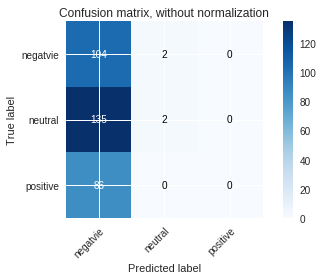

In [0]:
# calculate and print the confusion matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


class_names = ['negatvie','neutral','positive']
# class_names = ['positive','neutral','negatvie']

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_1d, y_pred_1d, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(df['orginal_label'], df['scores'], classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()
